In [22]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/maxdokukin/Politician-Trades/main/Data/data/more_prices_processed.csv')
df

,Politician Name,Party,Chamber,State,Issuer Name,Ticker,Publication Date,Transaction Date,Reporting Gap,Owner,...,pd_avg,fd1,fd2,fd3,fd4,fd5,fd_avg,perf_delta,market_figure,transaction_eval
0,Tom Carper,Democrat,Senate,DE,Valero Energy Corp,VLO,2024-05-01,2024-04-11,19,Spouse,...,1.209969,-2.296713,-2.252921,NaN,NaN,NaN,-0.909927,-2.119896,PEAK,Very Good Decision
1,Tom Carper,Democrat,Senate,DE,Enbridge Inc,ENB,2024-05-01,2024-04-11,19,Spouse,...,-0.252576,0.845151,0.247809,NaN,NaN,NaN,0.218592,0.471169,DIP,Very Good Decision
2,Dan Newhouse,Republican,House,WA,Accenture PLC,ACN,2024-04-26,2024-04-10,15,Spouse,...,-0.529128,-0.846115,-1.839513,NaN,NaN,NaN,-0.537126,-0.007998,CTS_DOWN,Bad Decision
3,Dan Newhouse,Republican,House,WA,Analog Devices Inc,ADI,2024-04-26,2024-04-10,15,Spouse,...,0.124802,-2.411272,3.433819,NaN,NaN,NaN,0.204509,0.079707,CTS_UP,Good Decision
4,Dan Newhouse,Republican,House,WA,Booking Holdings Inc,BKNG,2024-04-26,2024-04-10,15,Spouse,...,-0.078200,-1.743609,0.397726,NaN,NaN,NaN,-0.269177,-0.190977,CTS_DOWN,Good Decision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31565,Alan Lowenthal,Democrat,House,CA,Americold Realty Trust,COLD,2021-03-24,2021-03-15,8,Spouse,...,0.285091,1.032183,0.774360,0.126377,-0.418364,0.288625,0.360636,0.075545,CTS_UP,Bad Decision
31566,Mark Green,Republican,House,TN,NGL Energy Partners LP,NGL,2021-03-21,2021-03-17,3,Undisclosed,...,-0.918886,-3.743590,1.911907,-0.990951,1.222489,0.218236,-0.276382,0.642504,CTS_DOWN,Bad Decision
31567,Doug Lamborn,Republican,House,CO,NetApp Inc,NTAP,2021-03-20,2021-03-19,0,Spouse,...,0.777440,1.165335,0.645303,0.723262,0.162011,0.659658,0.671114,-0.106327,CTS_UP,Bad Decision
31568,Doug Lamborn,Republican,House,CO,NetApp Inc,NTAP,2021-03-20,2021-03-19,0,Undisclosed,...,0.777440,1.165335,0.645303,0.723262,0.162011,0.659658,0.671114,-0.106327,CTS_UP,Bad Decision


In [29]:
# global vars
party_colors = {
        'Democrat': '#0015BC',
        'Republican': '#DE0100',
        'Other': '#777777',
    }

info_by_name = df[['Politician Name', 'Party', 'Chamber', 'State']].drop_duplicates()
info_by_name = info_by_name.merge(df.groupby('Politician Name').size().reset_index(name='Total Transactions'), on="Politician Name")
# info_by_name = info_by_name.merge(trades.groupby('Politician Name').size().reset_index(name='Total Trade Cycles'), on="Politician Name")
info_by_name

,Politician Name,Party,Chamber,State,Total Transactions
0,Tom Carper,Democrat,Senate,DE,423
1,Dan Newhouse,Republican,House,WA,86
2,Jonathan Jackson,Democrat,House,IL,56
3,Sheldon Whitehouse,Democrat,Senate,RI,39
4,Ted Cruz,Republican,Senate,TX,1
...,...,...,...,...,...
162,Hakeem Jeffries,Democrat,House,NY,5
163,Richard Burr,Republican,Senate,NC,5
164,Elaine Luria,Democrat,House,VA,4
165,Mike Gallagher,Republican,House,WI,1


In [33]:
politician_decisions = df.groupby('Politician Name')['transaction_eval'].value_counts().reset_index(name='Decision Counts')
politician_decisions = politician_decisions.merge(info_by_name, on = 'Politician Name')
politician_decisions['Proportion of Decision'] = politician_decisions['Decision Counts'] / politician_decisions['Total Transactions'] * 100
politician_decisions.head(8)

,Politician Name,transaction_eval,Decision Counts,Party,Chamber,State,Total Transactions,Proportion of Decision
0,Adam Schiff,Very Good Decision,1,Democrat,House,CA,2,50.000000
1,Adam Schiff,Bad Decision,1,Democrat,House,CA,2,50.000000
2,Alan Lowenthal,Very Bad Decision,44,Democrat,House,CA,139,31.654676
3,Alan Lowenthal,Very Good Decision,35,Democrat,House,CA,139,25.179856
4,Alan Lowenthal,Good Decision,31,Democrat,House,CA,139,22.302158
5,Alan Lowenthal,Bad Decision,29,Democrat,House,CA,139,20.863309
6,Andrew Garbarino,Bad Decision,6,Republican,House,NY,14,42.857143
7,Andrew Garbarino,Very Good Decision,4,Republican,House,NY,14,28.571429


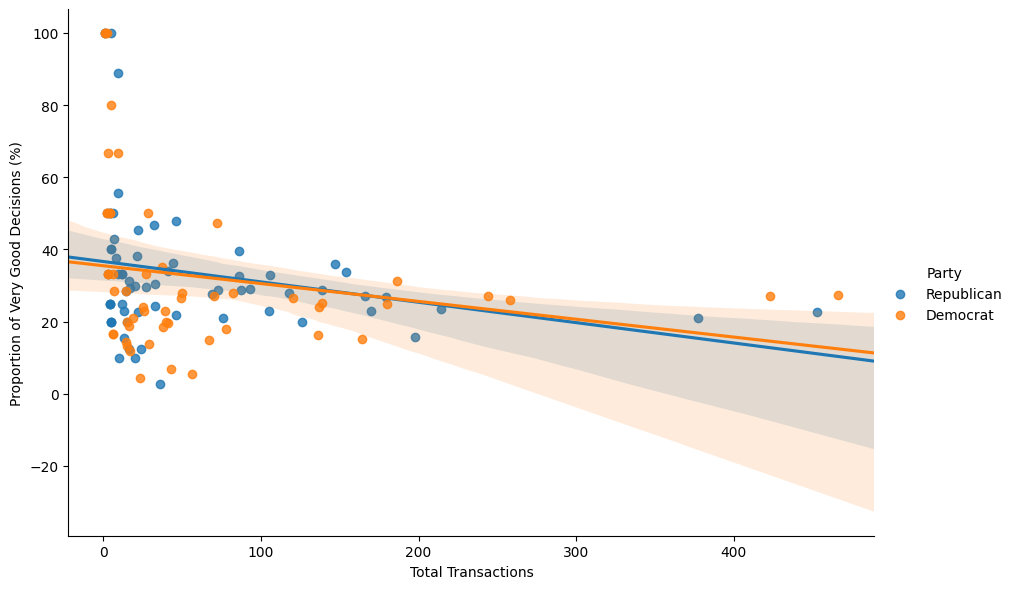

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = politician_decisions[politician_decisions['transaction_eval'] == 'Very Good Decision'].sort_values('Proportion of Decision', ascending=False)
plot_data = plot_data[plot_data['Total Transactions'] < 500]

# sns.lmplot(data=plot_data, x='count', y='proportion', hue='Party', order=4, truncate=False, height=6, aspect=1.5)
sns.lmplot(data=plot_data, x='Total Transactions', y='Proportion of Decision', hue='Party', order=1, truncate=False, height=6, aspect=1.5)

# plt.xlim(0, 100)
# plt.ylim(0, 100)
plt.ylabel('Proportion of Very Good Decisions (%)')
plt.show()

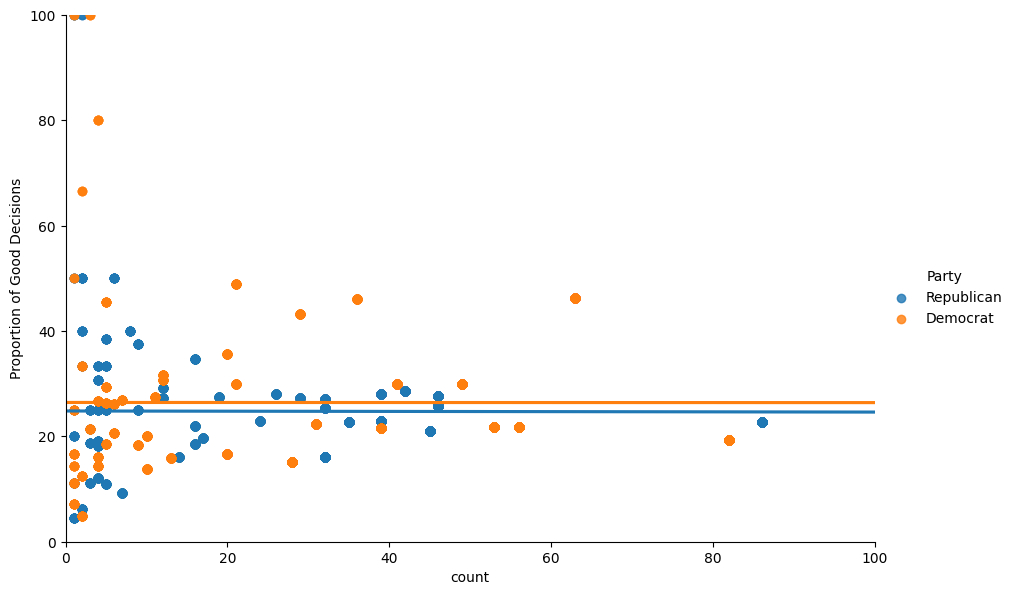

In [11]:
plot_data = palt[palt['transaction_eval'] == 'Good Decision'].sort_values('proportion', ascending=False)
sns.lmplot(data=plot_data, x='count', y='proportion', hue='Party', truncate=False, height=6, aspect=1.5)

plt.xlim(0, 100)
plt.ylim(0, 100)
plt.ylabel('Proportion of Good Decisions')
plt.show()

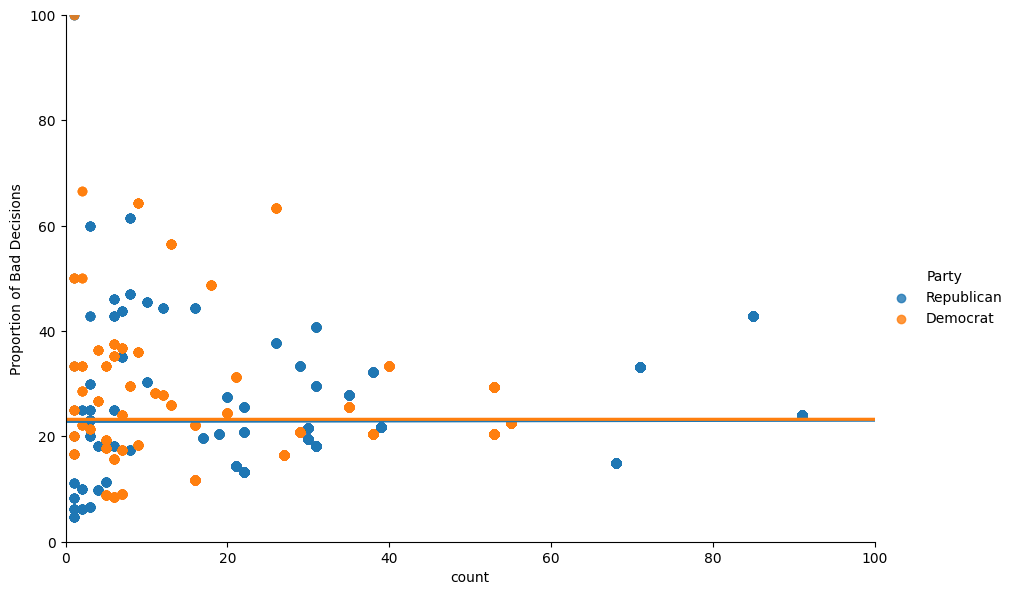

In [12]:
plot_data = palt[palt['transaction_eval'] == 'Bad Decision'].sort_values('proportion', ascending=False)
sns.lmplot(data=plot_data, x='count', y='proportion', hue='Party', truncate=False, height=6, aspect=1.5)

plt.xlim(0, 100)
plt.ylim(0, 100)
plt.ylabel('Proportion of Bad Decisions')
plt.show()

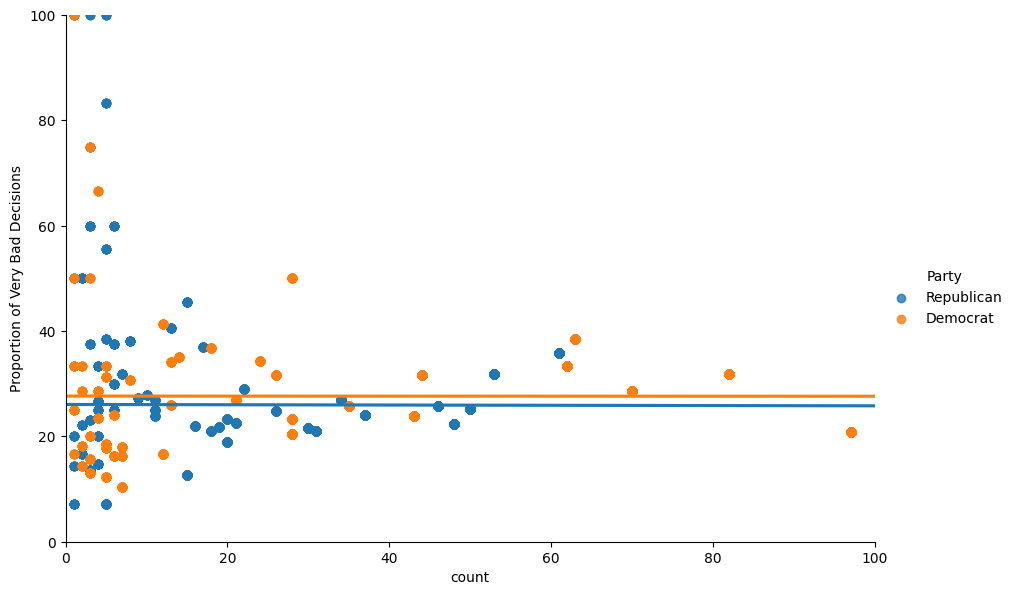

In [13]:
plot_data = palt[palt['transaction_eval'] == 'Very Bad Decision'].sort_values('proportion', ascending=False)
sns.lmplot(data=plot_data, x='count', y='proportion', hue='Party', truncate=False, height=6, aspect=1.5)

plt.xlim(0, 100)
plt.ylim(0, 100)
plt.ylabel('Proportion of Very Bad Decisions')
plt.show()